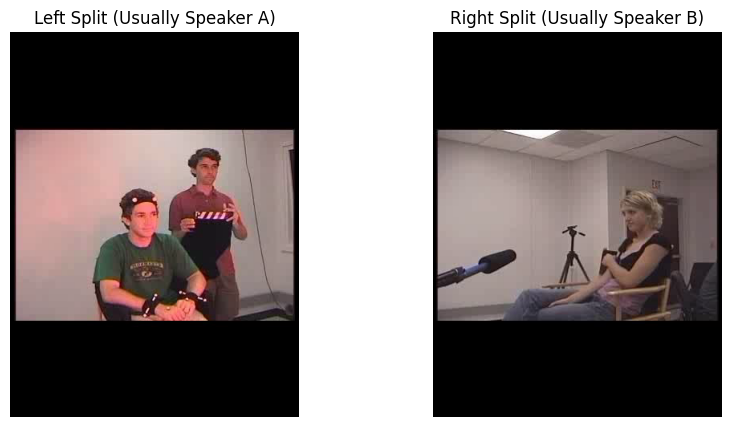

Original Resolution: 720x480
Split Resolution: 360x480


In [1]:
import cv2
import matplotlib.pyplot as plt
import os

# 1. Define the CORRECT path (removing '._')
# Adjust this base path to match where your folder actually is
video_path = "IEMOCAP_full_release/Session2/dialog/avi/DivX/Ses02M_script02_1.avi"

# 2. Check if file exists
if not os.path.exists(video_path):
    print(f"Error: File not found at {video_path}")
    print("Check if you are pointing to the '._' file by mistake!")
else:
    # 3. Load Video
    cap = cv2.VideoCapture(video_path)
    ret, frame = cap.read()
    cap.release()

    if ret:
        # Convert BGR (OpenCV) to RGB (Matplotlib)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # 4. Get Dimensions
        height, width, _ = frame_rgb.shape
        midpoint = width // 2
        
        # 5. Split the Frame (Numpy Slicing)
        # Left ROI: 0 to midpoint
        left_speaker = frame_rgb[:, 0:midpoint]
        
        # Right ROI: midpoint to end
        right_speaker = frame_rgb[:, midpoint:width]

        # 6. Display Side-by-Side
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        
        axes[0].imshow(left_speaker)
        axes[0].set_title("Left Split (Usually Speaker A)")
        axes[0].axis('off')
        
        axes[1].imshow(right_speaker)
        axes[1].set_title("Right Split (Usually Speaker B)")
        axes[1].axis('off')
        
        plt.show()
        
        print(f"Original Resolution: {width}x{height}")
        print(f"Split Resolution: {midpoint}x{height}")
    else:
        print("Error: Could not read frame from video.")

In [2]:
import cv2
import os
from tqdm import tqdm  # specific library for progress bars

# 1. Configuration
source_path = "IEMOCAP_full_release/Session2/dialog/avi/DivX/Ses02M_script02_1.avi"
output_dir = "split_videos"
os.makedirs(output_dir, exist_ok=True)

# Output Paths
out_left_path = os.path.join(output_dir, "left_speaker.avi")
out_right_path = os.path.join(output_dir, "right_speaker.avi")

# 2. Setup Video Capture
cap = cv2.VideoCapture(source_path)

if not cap.isOpened():
    print(f"Error: Could not open video {source_path}")
else:
    # Get Video Properties
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    # Calculate new width for split videos
    half_width = width // 2

    print(f"Processing: {total_frames} frames at {fps} FPS")
    print(f"Original Size: {width}x{height} -> Split Size: {half_width}x{height}")

    # 3. Setup Video Writers
    # 'XVID' is a safe codec for .avi files
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    
    out_left = cv2.VideoWriter(out_left_path, fourcc, fps, (half_width, height))
    out_right = cv2.VideoWriter(out_right_path, fourcc, fps, (half_width, height))

    # 4. Processing Loop
    for _ in tqdm(range(total_frames), desc="Splitting Video"):
        ret, frame = cap.read()
        if not ret:
            break
            
        # Split the frame
        left_frame = frame[:, :half_width]
        right_frame = frame[:, half_width:]
        
        # Write to respective files
        out_left.write(left_frame)
        out_right.write(right_frame)

    # 5. Cleanup
    cap.release()
    out_left.release()
    out_right.release()
    print("\nSuccess! Videos saved to:", output_dir)

Processing: 9515 frames at 29.97 FPS
Original Size: 720x480 -> Split Size: 360x480


Splitting Video: 100%|█████████▉| 9514/9515 [00:13<00:00, 695.60it/s]


Success! Videos saved to: split_videos


In [3]:
import cv2
import os

# Force CPU to avoid CUDA/CuDNN version mismatch
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from deepface import DeepFace
from collections import Counter

def get_gender(video_path, seconds=10):
    if not os.path.exists(video_path):
        print(f"Error: {video_path} not found.")
        return "Unknown"

    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    if fps == 0:
        print(f"Error: Could not read FPS for {video_path}")
        return "Unknown"
        
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = frame_count / fps
    
    # Analyze limited seconds or full video if shorter
    analyze_frames = int(min(duration, seconds) * fps)
    
    genders = []
    
    # Sample 1 frame per second to save time
    for i in range(0, analyze_frames, int(fps)):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if not ret:
            break
        try:
            # Enforce detection False to handle frames where face might not be clear
            # Use retinaface for better accuracy on CPU (might be slower but more accurate)
            result = DeepFace.analyze(frame, actions=['gender'], detector_backend='retinaface', enforce_detection=False, silent=True)
            if isinstance(result, list):
                result = result[0]
            genders.append(result['dominant_gender'])
            print(f"Frame {i}: {result['dominant_gender']}")
        except Exception as e:
            # print(f"Frame {i}: Error - {e}")
            pass
            
    cap.release()
    
    if not genders:
        return "Unknown"
        
    offset_gender = Counter(genders).most_common(1)[0][0]
    return offset_gender

if __name__ == "__main__":
    split_dir = "split_videos"
    videos = ["left_speaker.avi", "right_speaker.avi"]
    
    layout = {}
    
    for vid in videos:
        path = os.path.join(split_dir, vid)
        print(f"Analyzing {path}...")
        gender = get_gender(path)
        print(f"Result for {vid}: {gender}")
        layout[vid] = gender
        
    print("\nFinal Results:")
    print(layout)


2026-02-24 22:32:30.203239: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-24 22:32:30.240697: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Analyzing split_videos/left_speaker.avi...


2026-02-24 22:32:32.324822: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1771950752.326005   40273 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9816 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6
2026-02-24 22:32:34.577239: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002


Frame 0: Man
Frame 29: Man
Frame 58: Man
Frame 87: Man
Frame 116: Man
Frame 145: Man
Frame 174: Man
Frame 203: Man
Frame 232: Man
Frame 261: Man
Frame 290: Man
Result for left_speaker.avi: Man
Analyzing split_videos/right_speaker.avi...
Frame 0: Woman
Frame 29: Man
Frame 58: Man
Frame 87: Man
Frame 116: Man
Frame 145: Woman
Frame 174: Man
Frame 203: Man
Frame 232: Woman
Frame 261: Woman
Frame 290: Woman
Result for right_speaker.avi: Man

Final Results:
{'left_speaker.avi': 'Man', 'right_speaker.avi': 'Man'}
